## Simulate the runout of a landslide on a laboratory flume

### import necessary packages and components

In [1]:
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib import cm
import numpy as np

from landlab import RasterModelGrid
from landlab.components import FlowAccumulator, FlowDirectorMFD
from landlab import imshowhs_grid
from landlab.components.mass_wasting_router import MassWastingRunout

### define the flume dimensions, landslide (regolith) and MassWastingRunout parameters Sc, qsi and k

In [2]:
# add option of have just 1 flume or 2 combined flumes

# Define the flume
dxdy = 0.075
rows = 15 #
columns = 15 # must be odd number
ls_width = 3 # number of cells wide, must be odd number
ls_length = 5 # number of cells long
slope_above_break = 0.6
slope_below_break = 0.001
slope_break = .5 # ratio of flume 2 to place the slope break
soil_thickness = .06
Dp = 0.002 # particle diameter

# run parameters
qsc = 0.01 # pick qsc
Sc = 0.05 # critical slope
k = 0.0015 # coeficient multiplied by qsc to determine equivlanet alpha

### create the flume

#### a tool for making the laboratory flume

In [3]:
def flume_maker(rows = 5, columns = 3, slope_above_break =.5, slope_below_break =.05, slope_break = 0.7, 
                ls_width = 1, ls_length = 1, dxdy= 10, double_flume = False):
    """   
    Parameters
    ----------
    rows : integer
        number of rows in model domain. First and last row are used as boundaries
    columns : integer
        number of columns in domain. First and last column are used as boundaries
    slope_above_break : float
        slope of flume above break [m/m]
    slope_below_break : float
        slope of flume below break [m/m]
    slope_break : float
        ratio of length the slope break is placed, measured from the outlet
        slope break will be placed at closest node to slope_break value
    ls_width : odd value, integer
        width of landslide in number of cells, , must be <= than rows-2
    ls_length : integer
        length of landslide in number of cells, must be <= than rows-2
    dxdy : float
        side length of sqaure cell, [m]. The default is 10.
    double_flume : boolean
        False: makes just one flume; True: makes two flumes and puts attaches the lower end of
        one to the upper end of the other to make one long flume with a slope break in the middle
        of the flume
    
    Returns
    -------
    mg : raster model grid
        includes the field topographic__elevation
    lsn : np array
        0-d array of node id's that are the landslide
    pf : np array
        0-d array of node id's along the center of the flume. Used for profile
        plots.
    cc : np array
        0-d array of landslide node column id's'
    """
    def single_flume():
        r = rows
        c = columns
        sbr_r = slope_break
        if ls_width == 1:
            cc = int(c/2)+1
        elif (ls_width <= c) and (ls_width%2 == 1):
            cc = []
            for i in range(ls_width):
                dif = -((ls_width)%2)+i
                cc.append(int(c/2)+dif+1)
            cc = np.array(cc)
        mg = RasterModelGrid((r,c+2),dxdy)
        ycol = np.reshape(mg.node_y,(r,c+2))[:,0]
        yn = np.arange(r)
        yeL = []
        sb = (mg.node_y.max()*sbr_r)
        sbr = yn[ycol>=sb].min()
        sb = ycol[sbr]
        for y in ycol:
            if y<sb:
                ye = y*slope_below_break
            else:
                ye = (y-sb)*slope_above_break+sb*slope_below_break
            yeL.append(ye)
        dem = np.array([yeL,]*c).transpose()
        wall = np.reshape(dem[:,0],(len(dem[:,0]),1))+2*dxdy
        dem = np.concatenate((wall,dem,wall),axis =1)
        dem = np.hstack(dem).astype(float)
        _ = mg.add_field('topographic__elevation',
                            dem,
                            at='node')
        # profile nodes
        if ls_width == 1:
            pf = mg.nodes[:,cc]
        elif ls_width > 1:
            pf = mg.nodes[:,int(c/2)+1]
        # landslide nodes
        lsn = mg.nodes[-(ls_length+1):-1,cc]
        return mg, lsn, pf, cc

    if double_flume:
        mg1, lsn1, pf1, cc1 = single_flume()
        mg2, lsn2, pf2, cc2 = single_flume()
        mg = RasterModelGrid((rows*2,columns+2),dxdy)
        # translate mg1 vertically to the max height of mg2 minus the wall height plus the flume slope * dxdy
        t1 = mg1.at_node['topographic__elevation'] + mg2.at_node['topographic__elevation'].max()-dxdy*2+dxdy*slope_above_break
        t2 = mg2.at_node['topographic__elevation']
        topo = np.concatenate((t2,t1))
        _ = mg.add_field('topographic__elevation',
                            topo,
                            at='node')
        nn = len(mg2.node_x)
        pf = np.concatenate((pf2,np.array(pf1+nn).astype(int)))
        cc = cc1
        lsn = lsn1+nn
    else:
        mg, lsn, pf, cc = single_flume()        
    return mg, lsn, pf, cc

In [4]:
mg, lsn, pf, cc = flume_maker(rows = rows, columns = columns, slope_above_break = slope_above_break
                              , slope_below_break = slope_below_break, slope_break = slope_break/2, 
                              ls_width = ls_width, ls_length = ls_length, dxdy = dxdy, double_flume = True)

In [5]:

dem = mg.at_node['topographic__elevation']


# mass wasting ide
mg.at_node['mass__wasting_id'] = np.zeros(mg.number_of_nodes).astype(int)
mg.at_node['mass__wasting_id'][lsn] = 1

# mg.at_node['topographic__elevation'][55] = mg.at_node['topographic__elevation'][55]+1.3

# domain for plots
xmin = mg.node_x.min(); xmax = mg.node_x.max(); ymin = mg.node_y.min(); ymax = mg.node_y.max()

# set boundary conditions, add flow direction
mg.set_closed_boundaries_at_grid_edges(True, True, True, True) #close all boundaries


mg.set_watershed_boundary_condition_outlet_id(cc,dem)
    
mg.at_node['node_id'] = np.hstack(mg.nodes)

# flow directions
fa = FlowAccumulator(mg, 
                      'topographic__elevation',
                      flow_director='FlowDirectorD8')
fa.run_one_step()

# hillshade for plots
mg.at_node['hillshade'] = mg.calc_hillshade_at_node(elevs=dem, alt=37., az=210.)


# soil thickness
thickness = np.ones(mg.number_of_nodes)*soil_thickness
mg.add_field('node', 'soil__thickness',thickness)

# round out lower part of failure surface
mg.at_node['soil__thickness'][lsn[0][0:]] = soil_thickness/2


# set particle diameter
mg.at_node['particle__diameter'] = np.ones(len(mg.node_x))*Dp


# # no soil thickness
# thickness = np.zeros(mg.number_of_nodes)*soil_thickness
# mg.add_field('node', 'soil__thickness',thickness)
# mg.at_node['soil__thickness'][lsn] = soil_thickness*np.ones(len(lsn))

# copy of initial topography
DEMi = mg.at_node['topographic__elevation'].copy()


### take a look at the flume, and location of the landslide on the flume

Zmin0.0, Zmax1.0956


<Axes: xlabel='Easting', ylabel='Northing'>

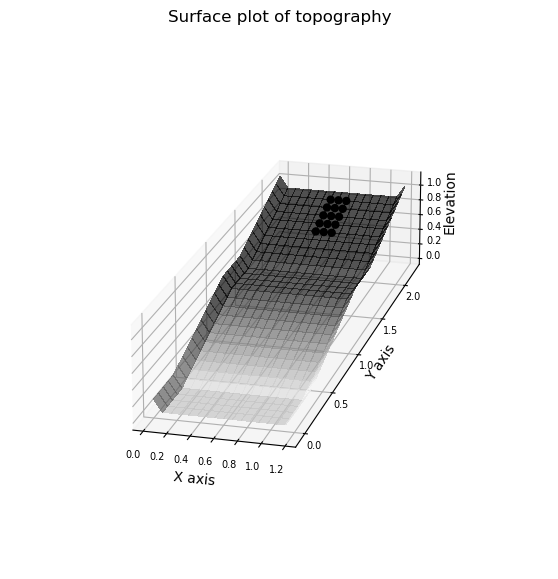

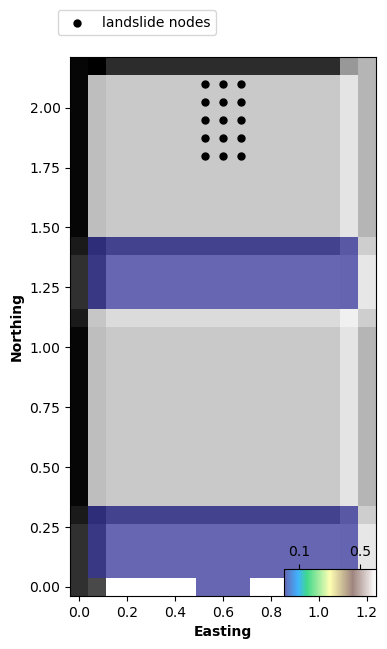

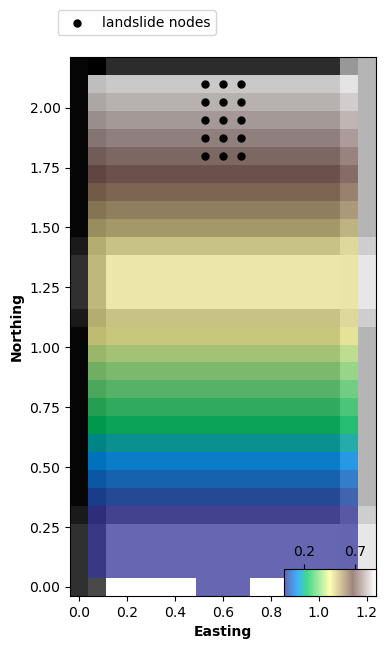

In [6]:
# borrow the plotting routine from the flow-director notebookks to make a 3d plot of our surface.
# import plotting tools
def surf_plot(mg,
              surface='topographic__elevation',
              title='Surface plot of topography'):

    fig = plt.figure(figsize = (7,7))
    ax = fig.add_subplot(projection='3d')
    # Plot the surface.
    Z = mg.at_node[surface].reshape(mg.shape)
    print('Zmin{}, Zmax{}'.format(Z.min(), Z.max()))
    color = cm.gray_r((Z - Z.min())*2 / (Z.max() - Z.min()))
    surf = ax.plot_surface(mg.x_of_node.reshape(mg.shape),
                           mg.y_of_node.reshape(mg.shape),
                           Z,
                           rstride=1,
                           cstride=1,
                           facecolors=color,
                           linewidth=0.,
                           antialiased=False,
                          alpha = 0.67)
    ax.view_init(elev=20, azim=-75)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Elevation')

    plt.title(title)
    ax.set_box_aspect([.30, 1, 0.2])
    ax.tick_params(axis = 'both', which = 'major', labelsize = 7)
    return ax

plt.show()

    
# 3d view
ax = surf_plot(mg)
ax.scatter(mg.node_x[lsn], mg.node_y[lsn], mg.at_node['topographic__elevation'][lsn], 
       marker = '.', color = 'k',alpha = 1, s = 100)

# 2d view
plt.figure(figsize = (7,7))
plt.scatter(mg.node_x[lsn], mg.node_y[lsn],
            marker = '.', color = 'k',alpha = 1, 
            s = 100, label = 'landslide nodes')
plt.legend(bbox_to_anchor=(.5, 1.1))
imshowhs_grid(mg,
            'topographic__elevation',
            drape1 = 'topographic__steepest_slope',
            cmap = 'terrain',
            allow_colorbar=True,
            plot_type=  "Drape1",
            alpha = 0.75,
            altdeg=37., azdeg=210)

# 2d view
plt.figure(figsize = (7,7))
plt.scatter(mg.node_x[lsn], mg.node_y[lsn],
            marker = '.', color = 'k',alpha = 1, 
            s = 100, label = 'landslide nodes')
plt.legend(bbox_to_anchor=(.5, 1.1))
imshowhs_grid(mg,
            'topographic__elevation',
            drape1 = 'topographic__elevation',
            cmap = 'terrain',
            allow_colorbar=True,
            plot_type=  "Drape1",
            alpha = 0.75,
            altdeg=37., azdeg=210)


In [7]:
#%% Add multiflow direction

# run flow director, add slope and receiving node fields
mg.delete_field(loc = 'node', name = 'flow__sink_flag')
mg.delete_field(loc = 'node', name = 'flow__link_to_receiver_node')
mg.delete_field(loc = 'node', name = 'flow__receiver_node')
mg.delete_field(loc = 'node', name = 'topographic__steepest_slope')

# run flow director, add slope and receiving node fields
fd = FlowDirectorMFD(mg, diagonals=True,
                      partition_method = 'square_root_of_slope')
# fd = FlowDirectorDINF(mg)
# fd = FlowDirectorD8(mg)
fd.run_one_step()


### now set up an instance of MassWastingRuntout to landslide and runout on the flume

In [8]:
mw_dict = {'critical slope':[Sc], 'threshold flux':qsc,
            'scour coefficient':k, 'effective particle diameter':Dp}
MWRu = MassWastingRunout(mg, mw_dict, effective_qsi = False, save = True, grain_shear = False, settle_deposit = True)

### run the instance of MassWastingRunout

In [9]:
start_time = time.time()
MWRu.run_one_step(run_id = 0)

20


### view runout extent

Zmin0.0, Zmax1.0956


<Axes: xlabel='Easting', ylabel='Northing'>

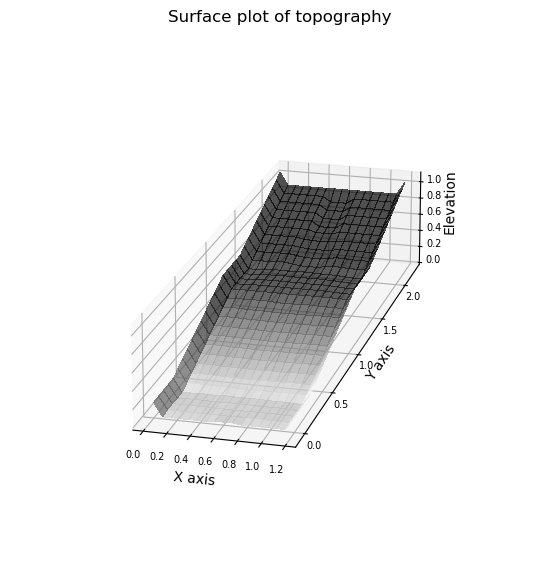

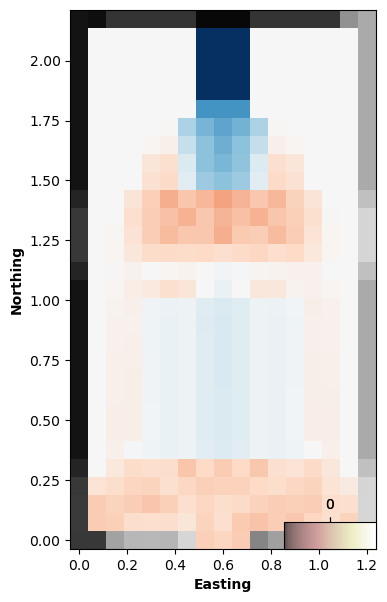

In [10]:
# change in topography is small relative to dimensions of flume

mg.at_node['dem_dif_o'] = mg.at_node['topographic__elevation']-mg.at_node['topographic__initial_elevation']

# 3d view
surf_plot(mg)

#2d view
plt.figure(figsize = (7,7))
imshowhs_grid(mg,
            'topographic__elevation',
            drape1 = 'topographic__elevation',
            drape2 = 'dem_dif_o',
            cmap2 = 'RdBu_r',
            allow_colorbar=True,
            plot_type=  "Drape2",
            limits = (-0.05,0.05),
            alpha = 0.75,
            altdeg=37., azdeg=210)

In [11]:
### view repeat images of runout process

<Figure size 1200x1200 with 0 Axes>

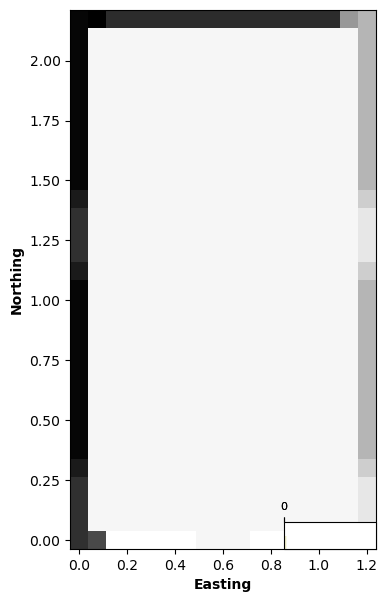

<Figure size 1200x1200 with 0 Axes>

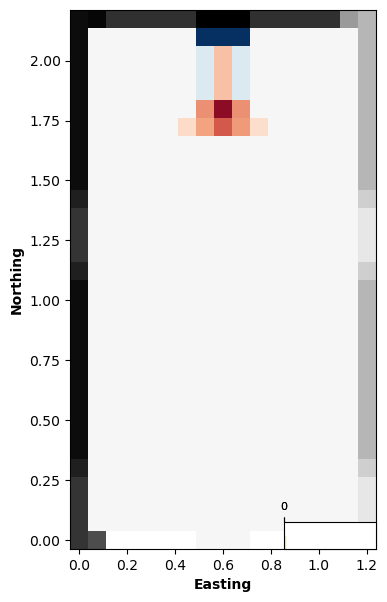

<Figure size 1200x1200 with 0 Axes>

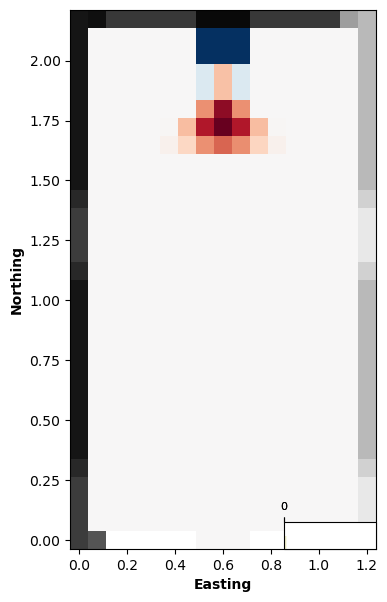

<Figure size 1200x1200 with 0 Axes>

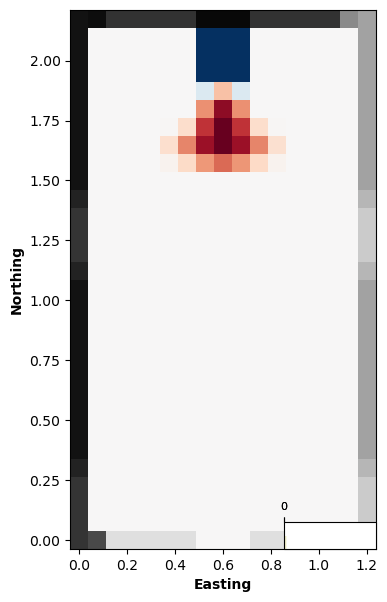

<Figure size 1200x1200 with 0 Axes>

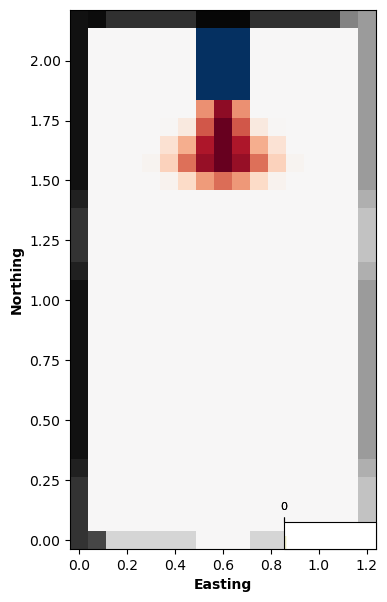

<Figure size 1200x1200 with 0 Axes>

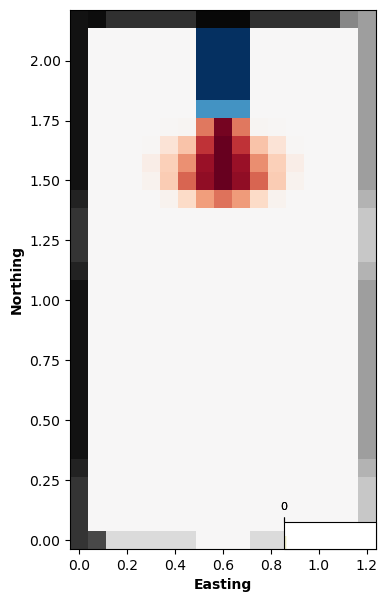

<Figure size 1200x1200 with 0 Axes>

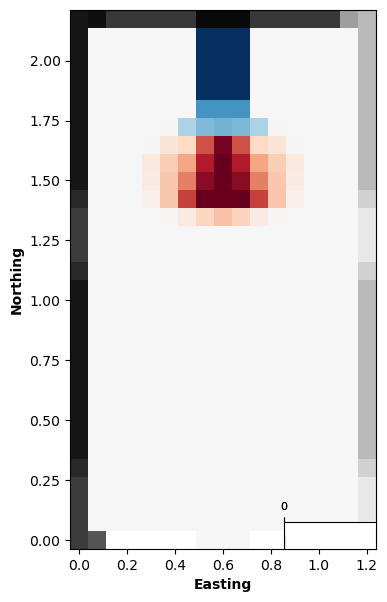

<Figure size 1200x1200 with 0 Axes>

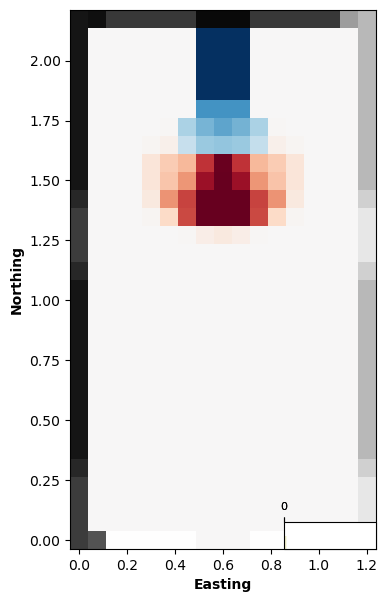

<Figure size 1200x1200 with 0 Axes>

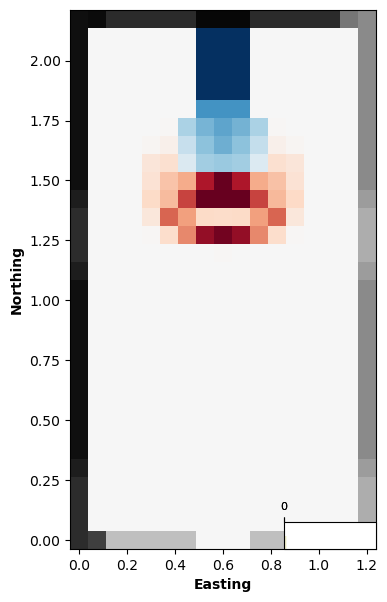

<Figure size 1200x1200 with 0 Axes>

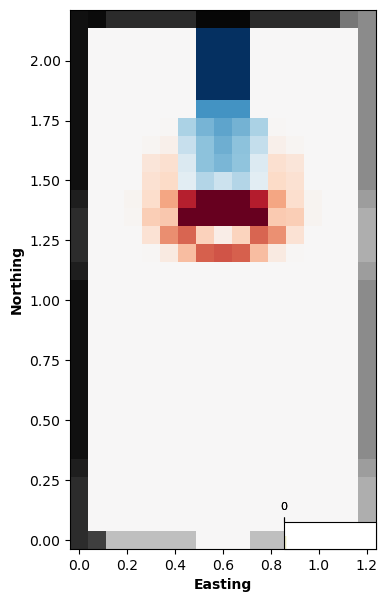

<Figure size 1200x1200 with 0 Axes>

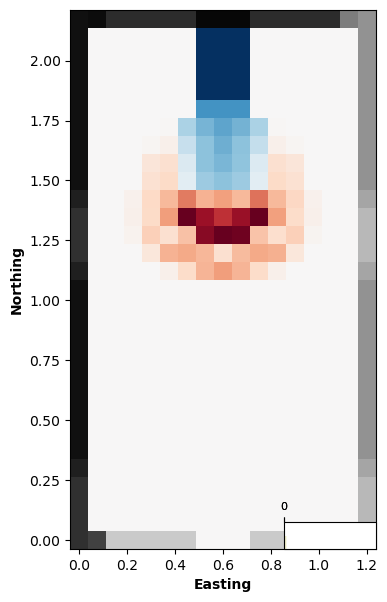

<Figure size 1200x1200 with 0 Axes>

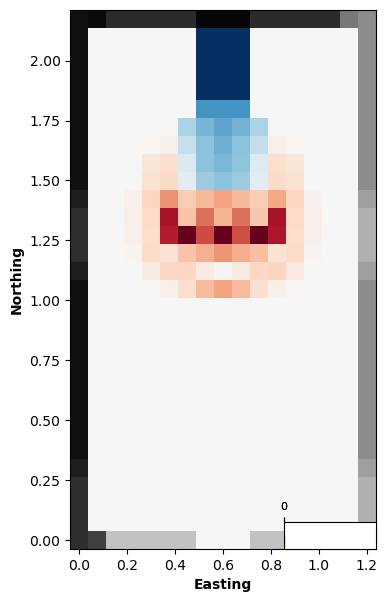

<Figure size 1200x1200 with 0 Axes>

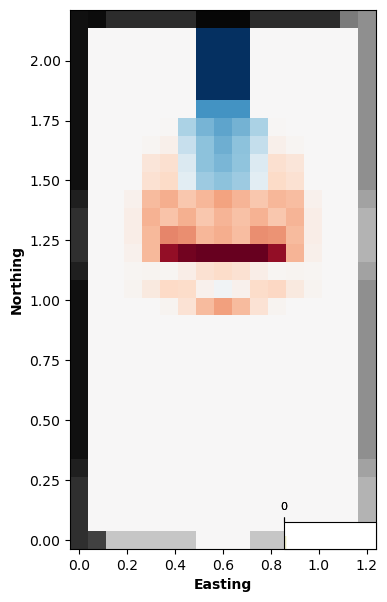

<Figure size 1200x1200 with 0 Axes>

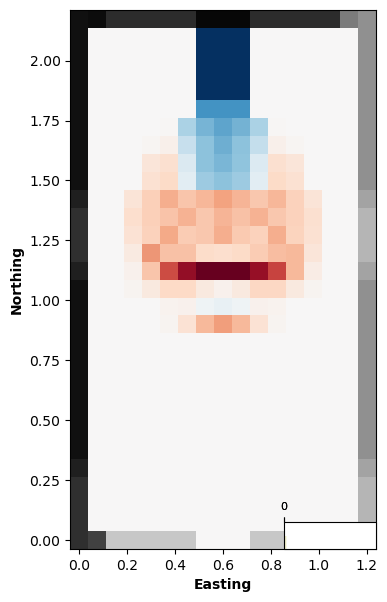

<Figure size 1200x1200 with 0 Axes>

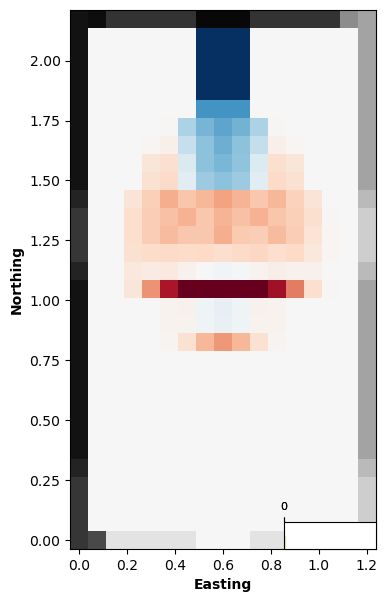

<Figure size 1200x1200 with 0 Axes>

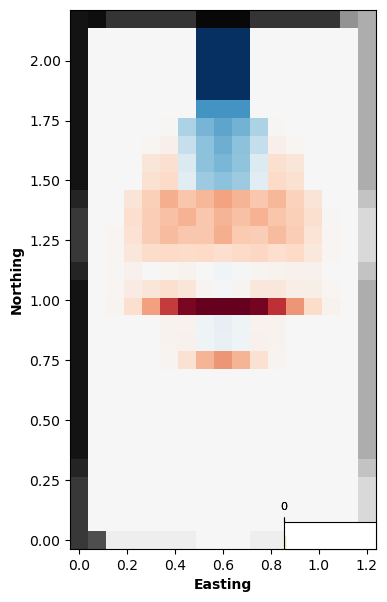

<Figure size 1200x1200 with 0 Axes>

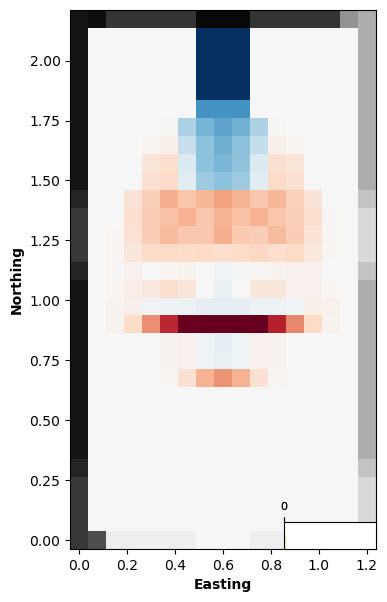

<Figure size 1200x1200 with 0 Axes>

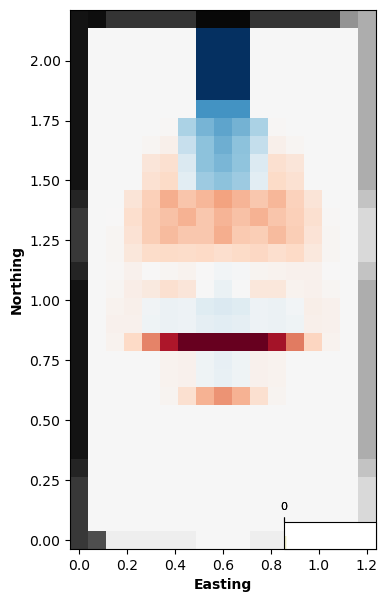

<Figure size 1200x1200 with 0 Axes>

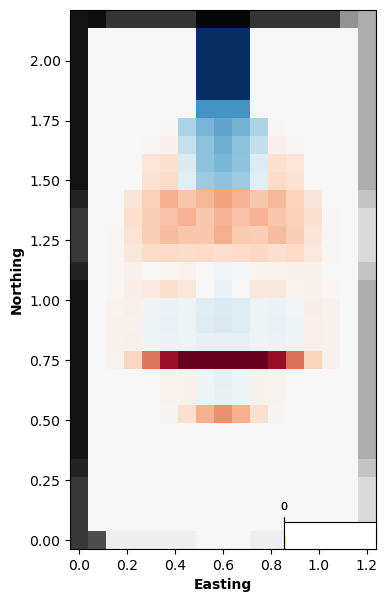

<Figure size 1200x1200 with 0 Axes>

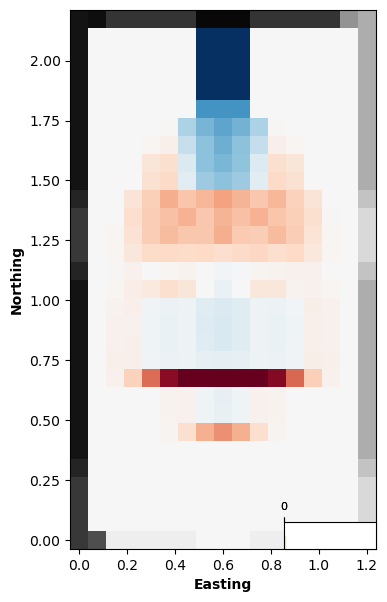

<Figure size 1200x1200 with 0 Axes>

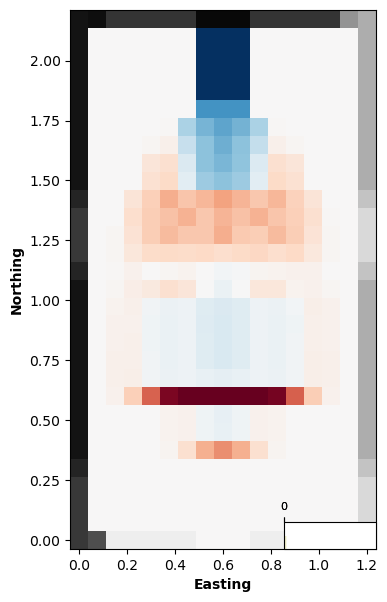

<Figure size 1200x1200 with 0 Axes>

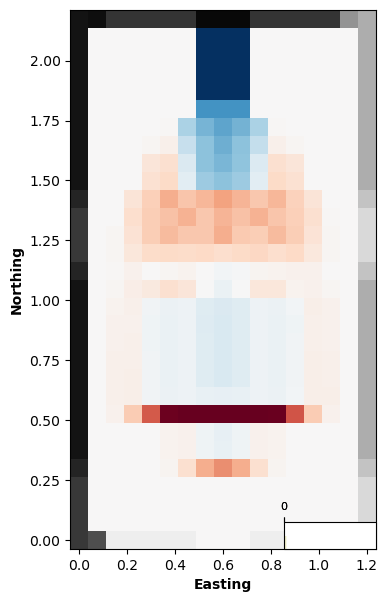

<Figure size 1200x1200 with 0 Axes>

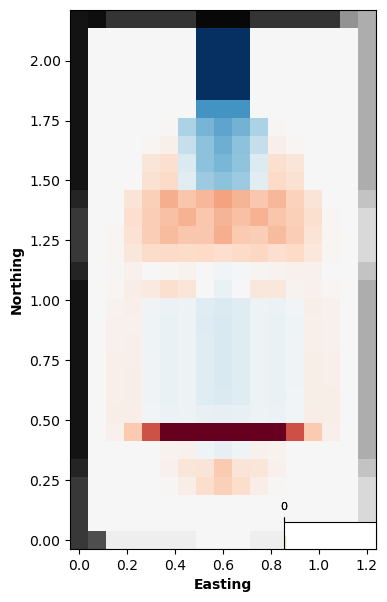

<Figure size 1200x1200 with 0 Axes>

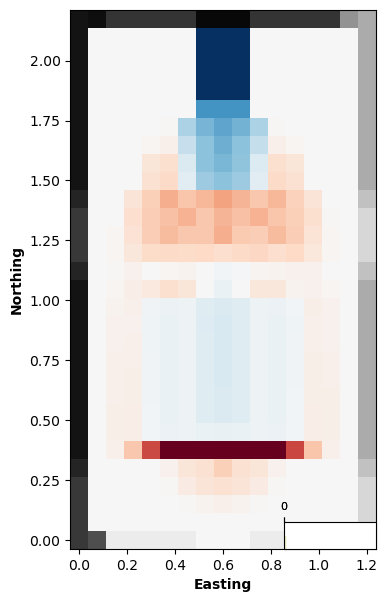

<Figure size 1200x1200 with 0 Axes>

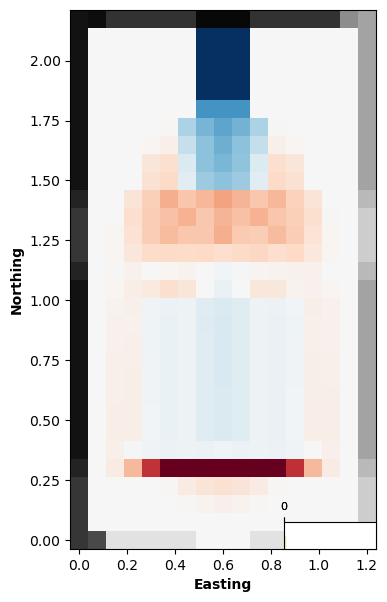

<Figure size 1200x1200 with 0 Axes>

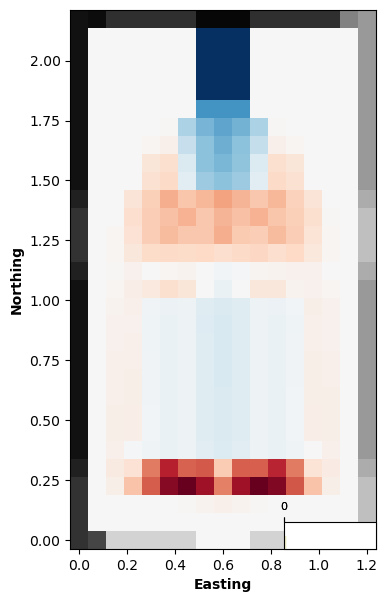

<Figure size 1200x1200 with 0 Axes>

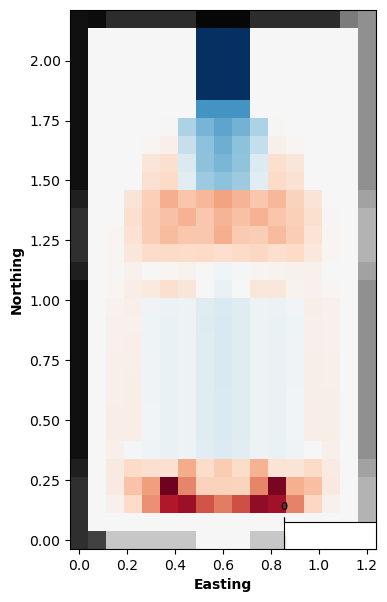

<Figure size 1200x1200 with 0 Axes>

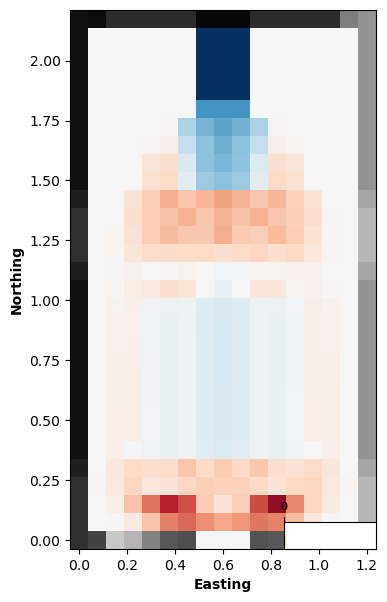

<Figure size 1200x1200 with 0 Axes>

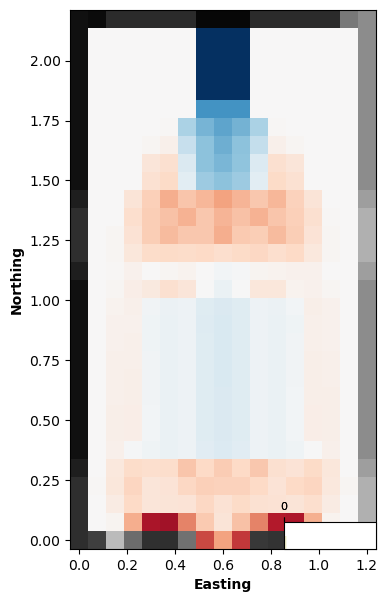

<Figure size 1200x1200 with 0 Axes>

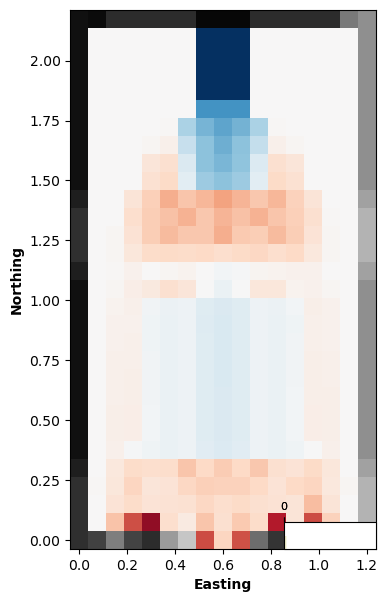

<Figure size 1200x1200 with 0 Axes>

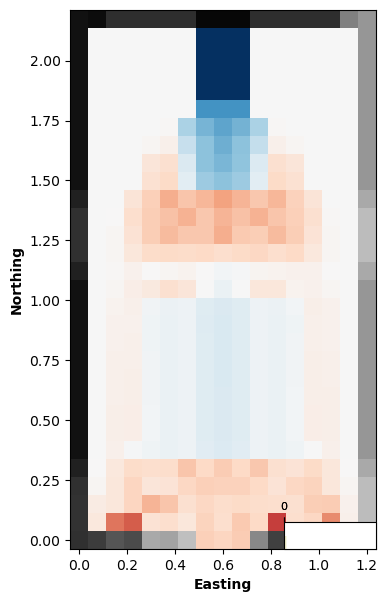

<Figure size 1200x1200 with 0 Axes>

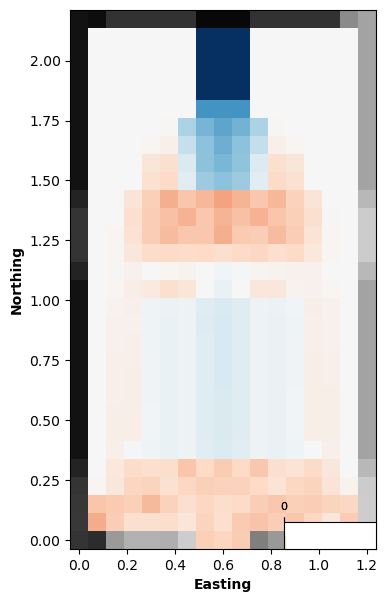

<Figure size 1200x1200 with 0 Axes>

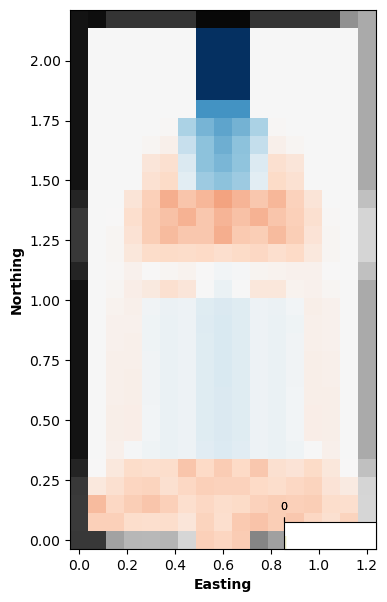

In [12]:
# plot how DEM changes
for i in np.arange(0,len(MWRu.mw_ids)):
    for c in MWRu.runout_evo_maps[i].keys():                  
        plt.figure('topography'+str(c)+str(i),figsize=(12, 12))
        mg.at_node['topographic__elevation'] = MWRu.runout_evo_maps[i][c]
        mg.at_node['df_topo'] = MWRu.runout_evo_maps[i][c]-mg.at_node['topographic__initial_elevation']
        field = "node_id"
        plt.figure(figsize = (7,7))
        
        imshowhs_grid(mg,
                    'topographic__elevation',
                    drape1 = 'topographic__elevation',
                    drape2 = 'df_topo',  
                    cmap2 = 'RdBu_r',
                    allow_colorbar=True,
                    plot_type=  "Drape2",
                    limits = (-0.05,0.05),
                    alpha = 0.75,
                    altdeg=37., azdeg=210)
        
        plt.xticks(fontsize= 8 )
        plt.yticks(fontsize= 8 )
        plt.xlim([xmin*.8,xmax*1.2]); plt.ylim([ymin*.3,ymax])
        plt.show()

        if c >50:
            break

C:\Users\keckje\AppData\Local\Temp\ipykernel_13308\290136255.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize = (6,3))


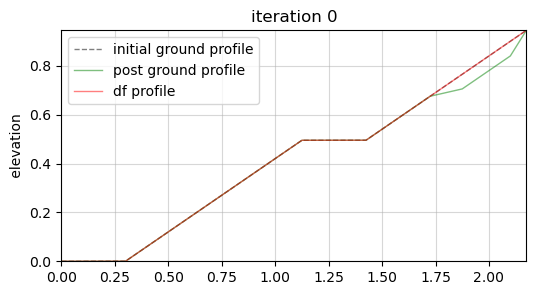

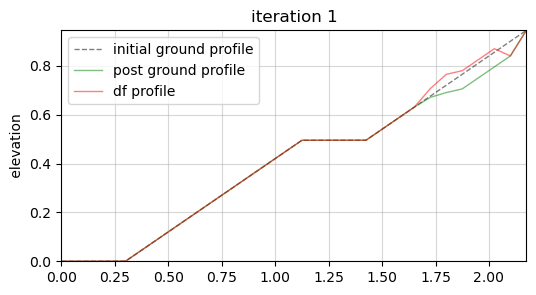

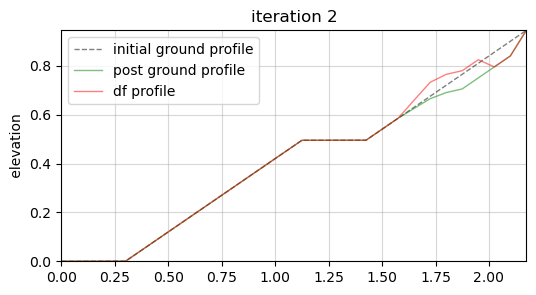

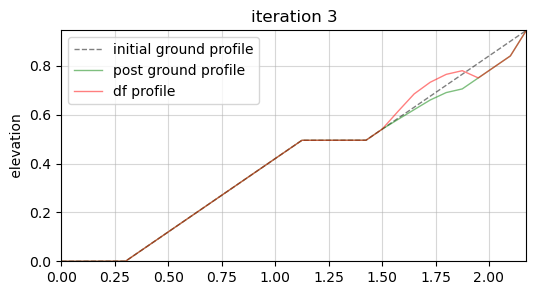

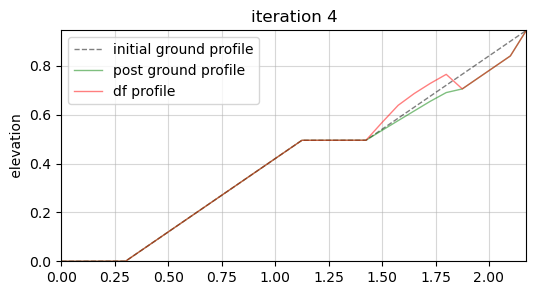

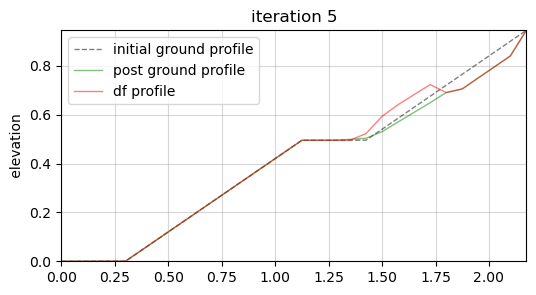

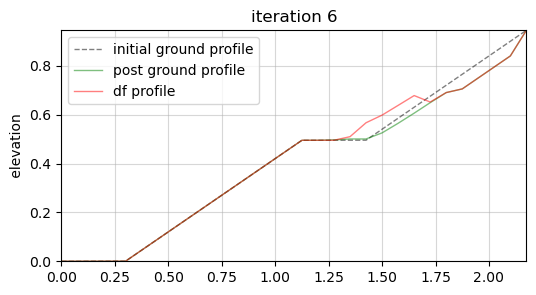

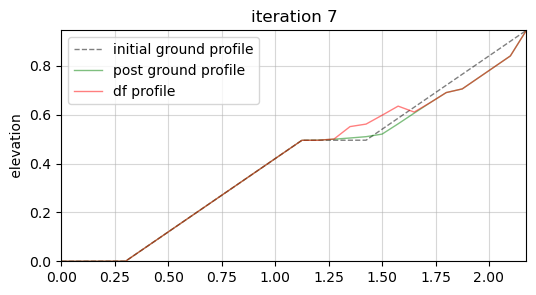

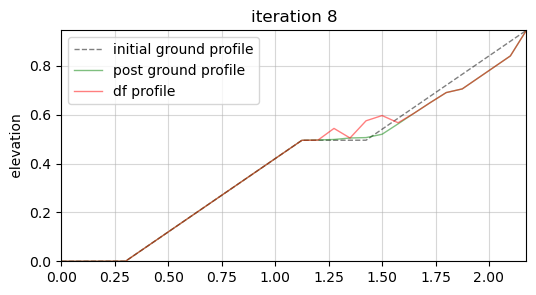

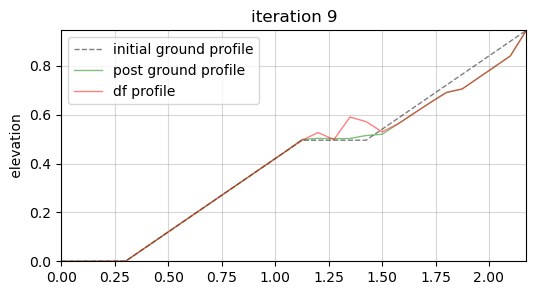

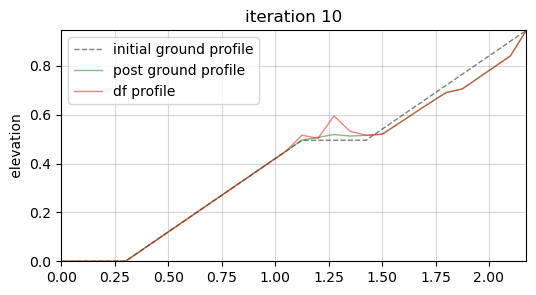

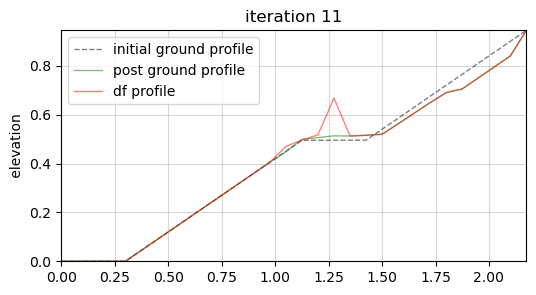

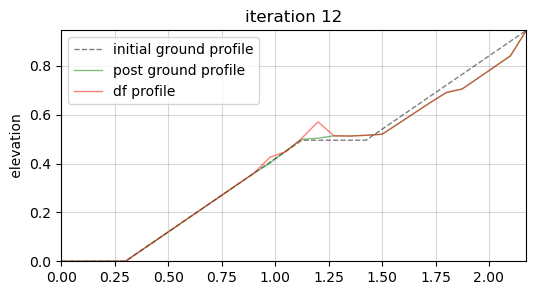

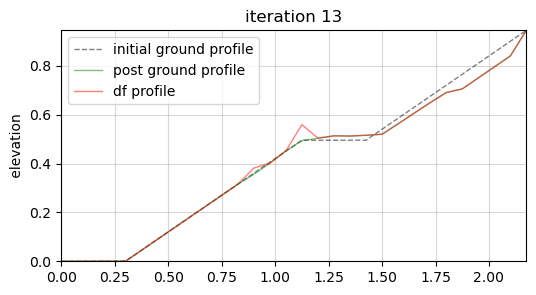

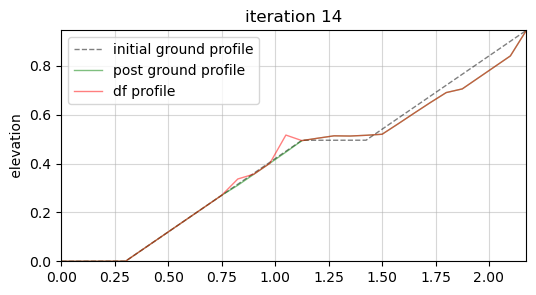

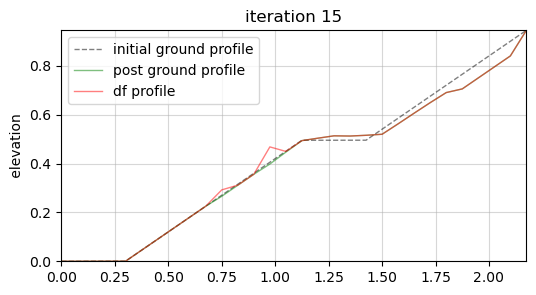

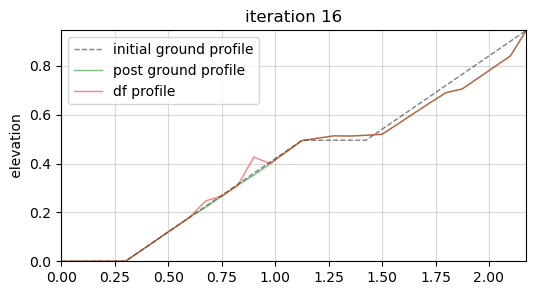

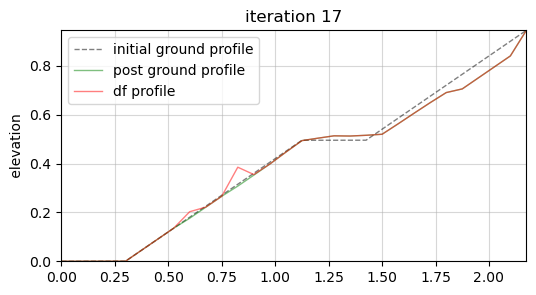

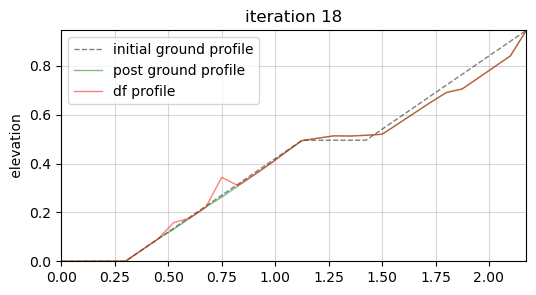

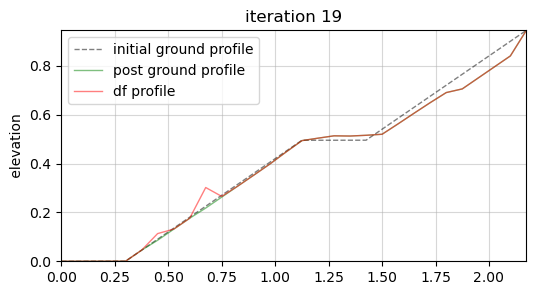

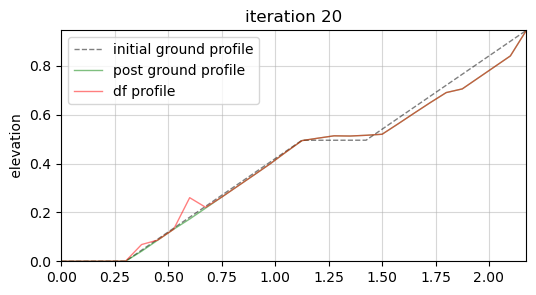

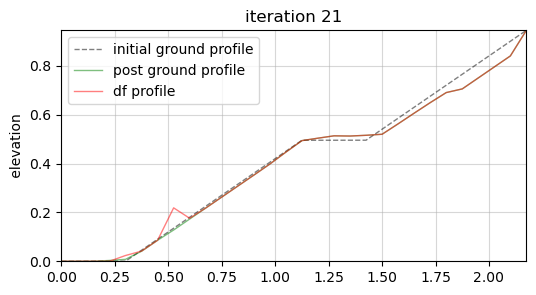

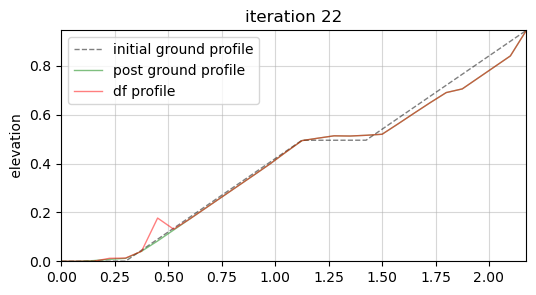

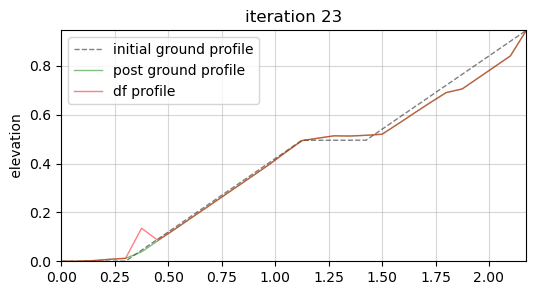

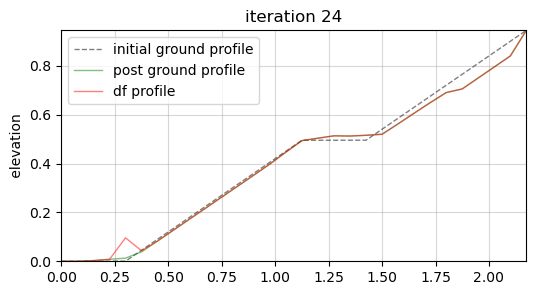

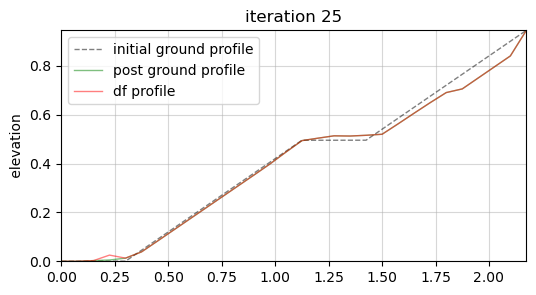

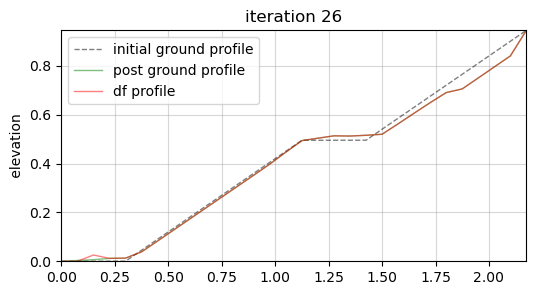

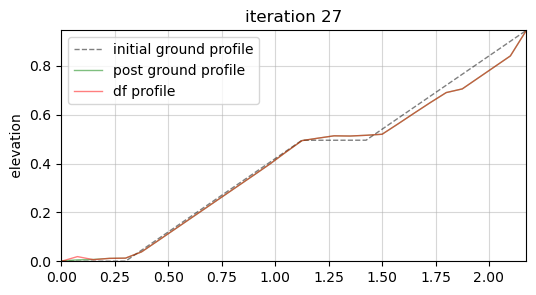

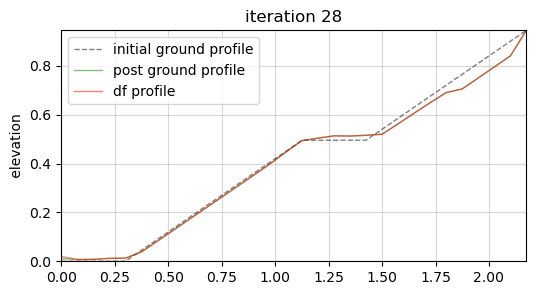

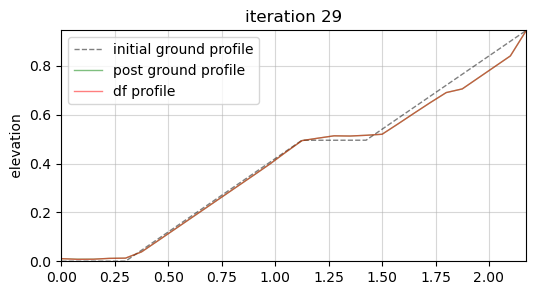

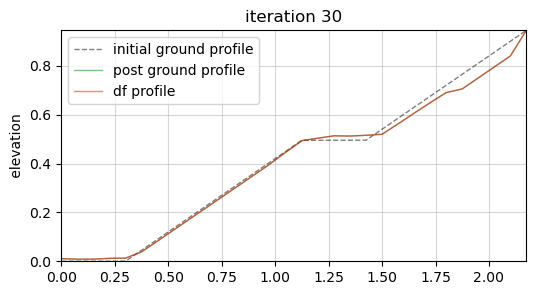

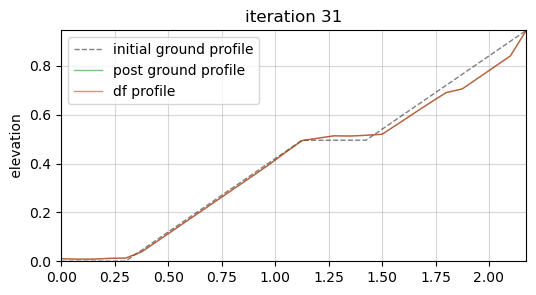

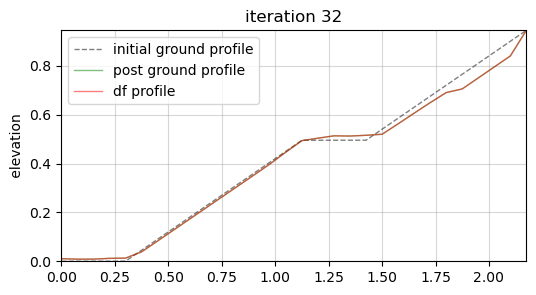

In [13]:
x_ = mg.node_y[pf]
y = mg.at_node['topographic__initial_elevation'][pf]


for i in np.arange(0,len(MWRu.mw_ids)):

    for c in MWRu.runout_evo_maps[i].keys():                  
        etopo = MWRu.runout_evo_maps[i][c]#-mg.at_node['topographic__initial_elevation']
        topo = MWRu.topo_evo_maps[i][c]
        # imshow_grid_at_node(mg,'df_topo',cmap ='RdBu_r')
        # if c>100:
        #     break                  
        y_ = topo[pf]
        _y_ = etopo[pf]
        plt.figure(figsize = (6,3))
        plt.plot(x_,y,'k--', alpha = 0.5, linewidth = 1,label = 'initial ground profile')
        plt.plot(x_,y_,'g-', alpha = 0.5, linewidth = 1, label = 'post ground profile')
        plt.plot(x_,_y_,'r-', alpha = 0.5, linewidth = 1, label = 'df profile')
        plt.ylim([0,max(y)]); plt.ylabel(' elevation ')
        plt.xlim([0, max(x_)])
        plt.legend()
        plt.grid(alpha = 0.5)  
        plt.title('iteration '+str(c))